In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import time as t
import matplotlib.pyplot as plt

Definimos o número de cenarios:

In [3]:
ncenarios=np.uint32(1e8)

# 1. CPU CODE

## 1.1. Definição do comportamento de um cenário:

In [4]:
def generateCenario():
    
    e1 , e2 , e3 = np.random.randn() , np.random.randn() , np.random.randn()

    t1 = 2  + 1*e1
    t2 = 5  + 1*e2
    t3 = 2  + 0.5*e3
    
    tempo = t1 + t2 + t3
    custo = 100000*tempo
    
    return tempo, custo

## 1.2. Simulação dos cenários:

In [5]:
cenarios_tempo = np.zeros(ncenarios)
cenarios_custo = np.zeros(ncenarios)

start = t.time()

for ncen in range(ncenarios):
    cenarios_tempo[ncen], cenarios_custo[ncen] = generateCenario()
        
total_time_cpu = t.time()-start

## 1.3. Resultados (Tempo de execução):

In [6]:
print('CPU: in %f secs' % (total_time_cpu))

CPU: in 168.524678 secs


## 1.5. Visualização de resultados:

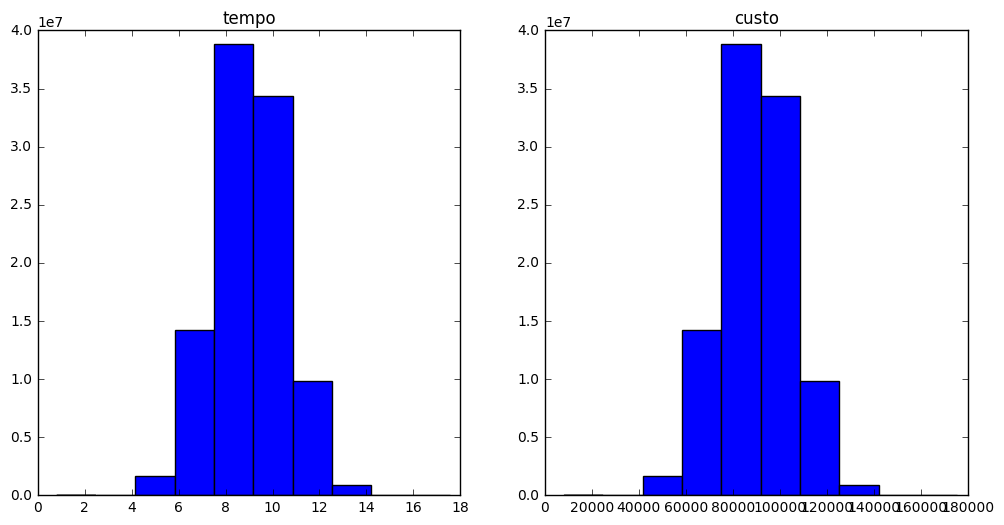

In [7]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.hist(cenarios_tempo)
plt.title('tempo')
plt.subplot(122)
plt.hist(cenarios_custo)
plt.title('custo')
plt.show()

## 1.4. Análise dos cenários:

In [8]:
cenarios_custo_ok=np.sum(np.apply_along_axis(lambda x: x<100000, axis=0 , arr=cenarios_custo))

p = (cenarios_custo_ok/len(cenarios_custo))*100

print( "Probabilidade de ter um precio de produção maior a 150000 é :  %f" % p)

Probabilidade de ter um precio de produção maior a 150000 é :  74.756966


# 2. GPU CODE

In [9]:
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
from pycuda.curandom import rand as curand

## 2.1. Definimos o comportamento dos cenários:

In [10]:
kernel = SourceModule("""
__device__ void generateCenarioGPU(float &t, float &custo, float *rand)
{
    float t1 , t2 , t3, e1 , e2 , e3;
    
    e1 =(2*rand[0]-1);
    e2 =(2*rand[1]-1);
    e3 =(2*rand[2]-1);
    
    t1 =  2 + 1*e1;
    t2 =  5 + 1*e2;
    t3 = 2.0 + 0.5*e3;
    
    t = t1 + t2 + t3;
    custo = 100000*t;
    
}

__global__ void generateCenariosGPU(float *cenarios_tempo,float *cenarios_custo, float *rand, unsigned int numcenarios)
{
    const unsigned int thread = blockIdx.x * blockDim.x + threadIdx.x;
    const unsigned int numthreads = blockDim.x * gridDim.x;
        
    for(unsigned int i=0 ; i<numcenarios ; i+=numthreads)
        generateCenarioGPU(cenarios_tempo[thread + i], cenarios_custo[thread + i], &rand[i*3]);
}
""")
generateCenarioGPU = kernel.get_function('generateCenariosGPU')

## 2.2. Simulação dos cenários:

In [11]:
cenarios_tempo_gpu = gpuarray.zeros(ncenarios, np.float32)
cenarios_custo_gpu = gpuarray.zeros(ncenarios, np.float32)

start = t.time()
rand_gpu = curand(3*ncenarios, dtype=np.float32)
generateCenarioGPU(cenarios_tempo_gpu, cenarios_custo_gpu, rand_gpu, ncenarios, block=(256,1,1), grid=(32,1))
total_time_gpu = t.time()-start

## 2.3. Resultados (Tempo de execução):

In [12]:
print('GPU: in %f secs' % (total_time_gpu))

GPU: in 0.150359 secs


## 2.5. Visualização de resultados:

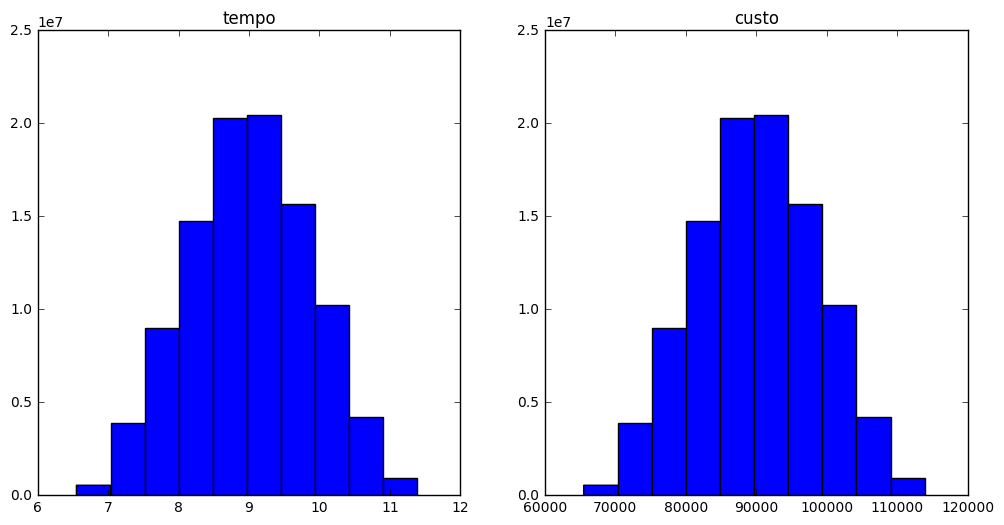

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.hist(cenarios_tempo_gpu.get())
plt.title('tempo')
plt.subplot(122)
plt.hist(cenarios_custo_gpu.get())
plt.title('custo')
plt.show()

## 2.4. Análise dos cenários:

In [14]:
cenarios_custo_cpu=cenarios_custo_gpu.get()
cenarios_custo_ok_cpu=np.sum(np.apply_along_axis(lambda x: x<100000, axis=0 , arr=cenarios_custo_cpu))

p = (cenarios_custo_ok_cpu/len(cenarios_custo_cpu))*100

print( "Probabilidade de ter um precio de produção maior a 150000 é :  %f" % p)

Probabilidade de ter um precio de produção maior a 150000 é :  86.515968


# 3. Speedup

In [15]:
speedup= total_time_cpu / total_time_gpu
print ("Speedup : %f" % speedup)

Speedup : 1120.812448
